# Signal processing Guitar tuner


by Diyun Lu and Yihan Zhong

# Import libraries and read wavfile

Import the libraries and get the names of the wav files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fftshift, fft
import math

In [2]:
file_path = "/Users/echo/Desktop/saclay/signal processing/assignments/"
wave_fname=[file_path + 'string_1.wav', file_path + 'string_2.wav', file_path + 'string_3.wav']

# Perform a spectral analysis

This step reads the audio file and turns the time series of an audio file into a numpy array with a default sampling rate. Sample rate is samples per second. The totale number of samples devide by sample rate will give the length of the audio. 

The amplitude of each audio file is stored in the notes list. The duration is stored in the length list.

In [4]:
notes=[]
length=[]
rates=[]
for i in range(len(wave_fname)):
  samplerate, data = wavfile.read(wave_fname[i])
  leng = data.shape[0] / samplerate
  notes.append(data)
  length.append(leng)
  rates.append(samplerate)

Plot the note in time series


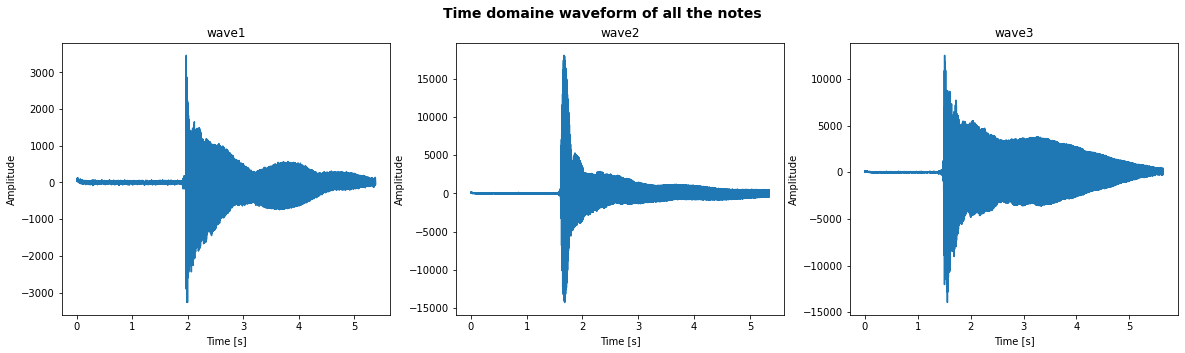

In [5]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(len(notes)):
    time = np.linspace(0., length[i], notes[i].shape[0])
    a = ax.ravel()[i]
    a.plot(time, notes[i])
    a.set_xlabel("Time [s]")
    a.set_ylabel("Amplitude")
    a.set_title(f'wave{i+1}')
fig.suptitle('Time domaine waveform of all the notes',fontsize = 14, fontweight ='bold')
plt.show()


## Plot the frequency domaine of the wave and find the peak

Plot the propertites parameters in the audio file.

Including the number of channels, sample width, frame rate, number of frames, and duration.

We plot the power spectrum of all note shown below. We can see the peaks acoording to different frequency.

In [13]:
import wave

dic_wave={'params':[],'Channels':[],'SampleRate':[],'frames':[],'Duration':[]}

for fname in wave_fname:
  wavFile = fname
  f = wave.open(wavFile)
  params = f.getparams()
  dic_wave.get('params').append(params)
  Channels = f.getnchannels()
  dic_wave.get('params').append(Channels)
  SampleRate = f.getframerate()
  dic_wave.get('SampleRate').append(SampleRate)
  frames = f.getnframes()
  dic_wave.get('frames').append(frames)
  Duration = wav_time = frames / float(SampleRate)
  dic_wave.get('Duration').append(Duration)
print(dic_wave)

{'params': [_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=237568, comptype='NONE', compname='not compressed'), 1, _wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=117912, comptype='NONE', compname='not compressed'), 1, _wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=124344, comptype='NONE', compname='not compressed'), 1], 'Channels': [], 'SampleRate': [44100, 22050, 22050], 'frames': [237568, 117912, 124344], 'Duration': [5.38702947845805, 5.3474829931972785, 5.639183673469388]}


According to the below plots, we can see different peaks at different frequency. But the maxinum usually appear in the first or the second.

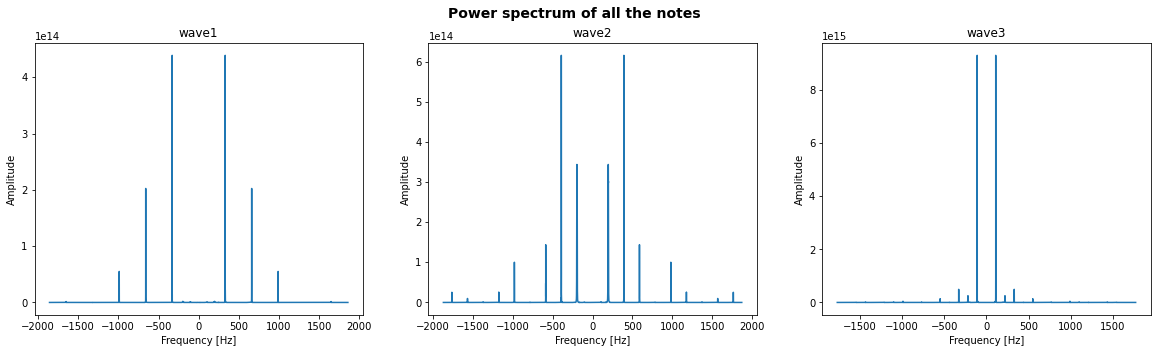

In [14]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(len(wave_fname)):
  a = ax.ravel()[i]
  Fs = dic_wave.get('SampleRate')[i] # in Hz
  T = dic_wave.get('Duration')[i] # in sec
  N = T*Fs; # in samples
  Freq = np.linspace(-Fs/2,Fs/2,int(N))
  x1_fft = fft(notes[i])
  x1_spectrum = fftshift(pow(np.abs(x1_fft),2)) # to get the 0 frequency in the middle
  length_freq = len(Freq)
  # To plot more clear, we only chose the middle parts to show below
  a.plot(Freq[length_freq//2-10000:length_freq//2+10000],x1_spectrum[length_freq//2-10000:length_freq//2+10000])
  a.set_xlabel("Frequency [Hz]")
  a.set_ylabel("Amplitude")
  a.set_title(f'wave{i+1}')
fig.suptitle('Power spectrum of all the notes',fontsize = 14, fontweight ='bold')
plt.show()

# Automatically determine the played note with the accuracy in cent

In order to etermine the play note and the accuracy in cent.
We got the Sample rate in Hz and the duration in second to calculate the samples to get the frequency list. 

After the Fourier Transform, we got the result x1_fft. With the use of x1_fft and the frequency list, we run the get_frequency_with_max_power function to get the frequency which has the max power.

Then we use the obtained frequency to compare with the different notes, in order to get the note which has the closest frequency. That will be the correct note, then we calculate the difference of frequency to get the accuracy in cent. For the threshold, we chose 350 Hz according to the frequency of the notes. If the frequency is larger then 350, then we will devide it by 2.

In [15]:
def get_frequency_with_max_power(x1_fft: list, freq_list: list) -> float:
  '''
  description: Get the frequnecy when the power is maxinum of the given list.
  param freq {list} the input frequency list
  param x1_fft {list} the result of Fourier Transform
  return {float} max_freq: certain frequnecy
  '''
  
  # to get the 0 frequency in the middle
  x1_spectrum = fftshift(pow(np.abs(x1_fft),2))
  # sort the frequency, to get the frequency when it's maxinum power.
  x1_spectrum,freq_list= zip(*sorted(zip(x1_spectrum,freq_list)))
  frequency = freq_list[-1]
  # if the frequency is larger then 350, then we will devide it by 2.
  if frequency >= 350:
    frequency = frequency // 2
  return frequency

In [16]:
E1 = 329.63 
B2 = 246.94 
G3 = 196.00 
D4 = 146.83 
A5 = 110.00 
E6 = 82.41 
note_dict = {"E1":E1, "B2":B2, "G3":G3, "D4":D4, "A5":A5, "E6":E6}
cent_accuracy_list = {"E1":0.15, "B2":0.15, "G3":0.15, "D4":0.08, "A5":0.08, "E6":0.04}

def get_note_with_accuracy(frequency: float):
  '''
  description: Get the correct note and the accuracy in cent.
  param frequency {float} the input frequency list
  return {float} note: the correct note
  return {float} accuracy: accuracy in cent
  '''
  if frequency >= 350:
    frequency = frequency // 2

  # compare the corresponding frequencies to get the correct note, which has the minimum difference
  freq_diffence_list = {"E1":abs(frequency-E1), "B2":abs(frequency-B2), "G3":abs(frequency-G3), 
                        "D4":abs(frequency-D4), "A5":abs(frequency-A5), "E6":abs(frequency-E6)}

  # the note will be near above frenquency, so we use the minimum frequency difference to get the correct note                      
  note = min(freq_diffence_list,key=freq_diffence_list.get)
  
  # use the difference of the frequency to calculate the accuracy in cent.
  freq_diffence = freq_diffence_list[note]
  accuracy = round(freq_diffence / cent_accuracy_list[note])
  return note, accuracy


In [17]:
for i in range(len(wave_fname)):
  a = ax.ravel()[i]
  Fs = dic_wave.get('SampleRate')[i] # in Hz
  T = dic_wave.get('Duration')[i] # in sec
  N = T*Fs # in samples
  Freq = np.linspace(-Fs/2,Fs/2,int(N))
  x1_fft = fft(notes[i])
  frequency = get_frequency_with_max_power(x1_fft, Freq)
  note, accuracy = get_note_with_accuracy(frequency)
  print("The frequency is {}. So this is note {} with accuracy in cent {}".format(frequency, note, accuracy))

The frequency is 329.77496874565986. So this is note E1 with accuracy in cent 1
The frequency is 196.0. So this is note G3 with accuracy in cent 0
The frequency is 110.2118736076809. So this is note A5 with accuracy in cent 3
